<a href="https://colab.research.google.com/github/lmuppala724/denoising_images/blob/main/U_Net_Noise_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 50.0 MB/s eta 0:00:00


In [2]:
#creating clean colour dataset array
import pandas as pd
import numpy as np
import os
import tifffile as tf
from PIL import Image
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir

clean_folder_str = "/content/drive/MyDrive/Dissertation/Dataset/ordered_train"
clean_en = os.fsencode(clean_folder_str)

clean_imgs = []

for file in sorted(os.listdir(clean_en)):
  filename = os.fsdecode(file)
  subdir = os.path.join(clean_folder_str, filename)
  if filename.endswith(".tiff"):
      image = tf.imread(subdir)
      clean_imgs.append(image)

In [9]:
#creating clean colour validation dataset array
import pandas as pd
import numpy as np
import os
import tifffile as tf
from PIL import Image
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir

clean_folder_str = "/content/drive/MyDrive/Dissertation/Dataset/ordered_val"
clean_en = os.fsencode(clean_folder_str)

val_imgs = []

for file in sorted(os.listdir(clean_en)):
  filename = os.fsdecode(file)
  subdir = os.path.join(clean_folder_str, filename)
  if filename.endswith(".tiff"):
      image = tf.imread(subdir)
      val_imgs.append(image)

In [3]:
#creating noise-noise dataset array
import pandas as pd
import numpy as np
import os
import tifffile as tf
from PIL import Image
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir

noisy1_folder_str = "/content/drive/MyDrive/Dissertation/Dataset/colour_poisson_noise_train_v1"
noisy1_en = os.fsencode(noisy1_folder_str)

noisy2_folder_str = "/content/drive/MyDrive/Dissertation/Dataset/colour_poisson_noise_train_v2"
noisy2_en = os.fsencode(noisy2_folder_str)

noisy1_imgs = []
noisy2_imgs = []

for file in sorted(os.listdir(noisy1_en)):
  filename = os.fsdecode(file)
  subdir = os.path.join(noisy1_folder_str, filename)
  if filename.endswith(".tiff"):
      image = tf.imread(subdir)
      noisy1_imgs.append(image)

for file in sorted(os.listdir(noisy2_en)):
  filename = os.fsdecode(file)
  subdir = os.path.join(noisy2_folder_str, filename)
  if filename.endswith(".tiff"):
      image = tf.imread(subdir)
      noisy2_imgs.append(image)


In [4]:
#U-Net
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np
import pytorch_lightning as pl
import torch.optim as optim

def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2)
    else:
        # out_channels is always going to be the same
        # as in_channels
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)


class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, 
                 merge_mode='concat', up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels, self.out_channels, 
            mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(
                2*self.out_channels, self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)


    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


class UNet(pl.LightningModule):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597

    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).

    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=3, 
                 start_filts=64, up_mode='transpose', 
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the 
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))
    
        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        encoder_outs = []
         
        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)
        
        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

    #To use Adam optimizer
    def configure_optimizers(self): 
        optimizer = optim.Adam(self.parameters(), lr=1e-4) #learning rate -lr
        #scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10) 
        
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler, 
           'monitor': 'val_loss'
       }

    def training_step(self, batch, batch_idx):
      prediction = self(batch[:,self.in_channels:2*self.in_channels,...]) #batch, channel-noisy image, y, x (x,y is the pixels)
      ground_truth = batch[:,0:self.in_channels,...]
      loss = ((prediction - ground_truth) ** 2).mean() 
      self.log("train_loss", loss)
      return loss

    def validation_step(self, batch, batch_idx):
      prediction = self(batch[:,self.in_channels:2*self.in_channels,...]) #batch, channel-noisy image, y, x (x,y is the pixels)
      ground_truth = batch[:,0:self.in_channels,...]
      loss = ((prediction - ground_truth) ** 2).mean() 
      self.log("val_loss", loss)
      return loss
    
    def test_step(self, batch, batch_idx):
      prediction = self(batch[:,self.in_channels:2*self.in_channels,...]) #batch, channel-noisy image, y, x (x,y is the pixels)
      ground_truth = batch[:,0:self.in_channels,...]
      loss = ((prediction - ground_truth) ** 2).mean() 
      self.log("test_loss", loss)
      return loss



In [5]:
import torch
from torchvision import transforms

class Noisy_Noisy_Dataset(torch.utils.data.Dataset):
  def __init__(self, data_noise1, data_noise2,  transform=None):
    self.data_noise1 = data_noise1
    self.data_noise2 = data_noise2
    self.transform = transform

  def __len__(self):
    return len(self.data_noise1)  

  def __getitem__(self,idx):
    #splitting the noise image can be done here, to randomise it every time
    noise1 = self.data_noise1[idx].astype(np.float32)
    noise1_trans = noise1.transpose(2,0,1)
    noise1_torch = torch.from_numpy(noise1_trans)/255.0
    
    noise2 = self.data_noise2[idx].astype(np.float32)
    noise2_trans = noise2.transpose(2,0,1)
    noise2_torch = torch.from_numpy(noise2_trans)/255.0

    combined = torch.cat((noise1_torch, noise2_torch), dim=0) #combines the two images on the first added dimension
    return self.transform(combined) #crops the image randomly to have same size
    


In [6]:
# Train model for Noisy-Noisy data
import torch.utils.data as dt

transform = transforms.RandomCrop(320)
train_dataset = Noisy_Noisy_Dataset(noisy1_imgs[:175], noisy2_imgs[:175], transform)
val_dataset = Noisy_Noisy_Dataset(noisy1_imgs[175:], noisy2_imgs[175:], transform)
train_loader = dt.DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, pin_memory=False)
val_loader = dt.DataLoader(val_dataset, batch_size=4, shuffle=True, drop_last=False,  pin_memory=False)


In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

network = UNet(3,3) #3 input channel 3 output channel for colour images
CHECKPOINT_PATH = '/content/drive/MyDrive/Dissertation/Dataset/models'

trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "Noisy_Noise_Training"),
                     gpus = [0], devices = [0],
                     max_epochs=200, 
                     callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                     LearningRateMonitor("epoch")])

                     #EarlyStopping('val_loss', patience=2000)])
trainer.fit(network, train_loader, val_loader)
checkpoint_path = trainer.checkpoint_callback.best_model_path


<ipython-input-4-d2868feb3c71>:214: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
<ipython-input-4-d2868feb3c71>:215: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:494: UserWarning: The flag `devices=[0]` will be ignored, instead the device specific number [0] will be used
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:p

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [7]:
import numpy as np

def psnr(img1, img2):
    # Convert the images to the same data type
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Calculate the mean squared error (MSE)
    mse = np.mean(np.square(img1 - img2))

    # Calculate the maximum pixel value
    max_i = np.amax(img1)

    # Calculate the PSNR using the MSE and maximum pixel value
    psnr = 20 * np.log10(max_i) - 10 * np.log10(mse)

    return psnr

<ipython-input-4-d2868feb3c71>:214: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
<ipython-input-4-d2868feb3c71>:215: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Average PSNR over validation set:  9.81891040802002


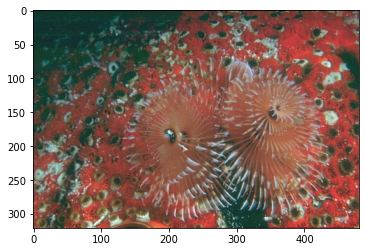

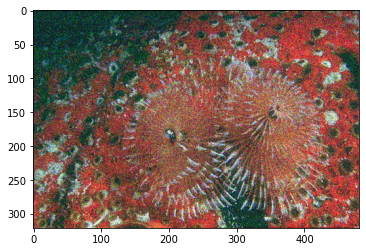

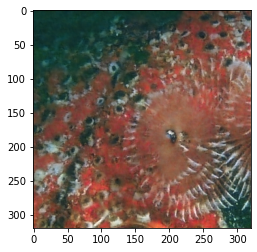

In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint

device = torch.device("cuda:0")

loaded_model = UNet.load_from_checkpoint("/content/drive/MyDrive/Dissertation/Dataset/models/Noisy_Noise_Training/lightning_logs/version_2/checkpoints/epoch=148-step=6407.ckpt", num_classes=3)

val_folder_str = "/content/drive/MyDrive/Dissertation/Dataset/colour_poisson_noise_val"
val_en = os.fsencode(val_folder_str)

noisy_imgs = []
psnr_total = 0

#creating the noisy images using binomial distribution and scaling up the dimmed image
for file in sorted(os.listdir(val_en)):
  filename = os.fsdecode(file)
  subdir = os.path.join(val_folder_str, filename)
  if filename.endswith(".tiff"):
      image = tf.imread(subdir)
      noisy_img = image * 10
      #noise_img = noisy_imgs[70] * 10
      noisy_imgs.append(noisy_img)

idx = 0
for img in noisy_imgs:
  idx = idx + 1
  noisy = img.transpose(2,0,1)
  noisy_transformed = noisy.astype(np.float32)
  noisy_new = torch.from_numpy(noisy_transformed[np.newaxis,:,:320,:320])/255.0 #crops to 320 on both axis
  output = loaded_model(noisy_new).detach().cpu()[0,...].numpy()
  clean = clean_imgs[idx]
  psnr_total += psnr(clean[:320, :320, :], output.transpose(1,2,0)*255) #Multiplying the output by 255 as the input to the network is normalised by dividing by 255

psnr_avg = psnr_total/idx
print("Average PSNR over validation set: ", psnr_avg)

clean = val_imgs[20]
plt.imshow(clean, vmin=0, vmax=255)
plt.show()

val_img = noisy_imgs[20]
plt.imshow(val_img, vmin=0, vmax=255)
plt.show()

noisy = val_img.transpose(2,0,1)
noisy_transformed = noisy.astype(np.float32)
noisy_new = torch.from_numpy(noisy_transformed[np.newaxis,:,:320,:320])/255.0
output = loaded_model(noisy_new).detach().cpu()[0,...].numpy()
output_trans = output.transpose(1,2,0)
plt.imshow(output_trans, vmin=0, vmax=255)
plt.show()